In [ ]:
MA 5831: Assessment One:  Recommender System
Paul Kirkwood

Introduction
#intro to describe purpose, etc, approach, etc.

Python Information

- Python version 3.9.3 implemented via CondaForge
- Pycharm IDE: Version 12.2.2 Professional Edition

In [5]:
#setup Libraries
import time

import pandas as pd
import numpy as np
import json
import requests

In [2]:
data = pd.read_excel(r'MA5851_SP86_2021_A1_Data.xlsx') #read xlsx from local drive
data.drop_duplicates() # check for duplicate rows
print(data.isnull().sum()) #check for null entries,
#Add unique identifier
data = pd.DataFrame(data)
# Searches to be performed using API calls to repositories.
# Call will be made using the ISBN values.
isbn_list = data['ISBN']
len(isbn_list)
#scale of dataset is large and slow for testing. Generate test set for API tests
test_isbn = isbn_list[:10]
test_isbn.head
#Create Datasets for modelling
data.head()
data_subset = data[['School_ID','State', 'Year', 'Subject', 'ISBN']]
data_subset.head()

School_ID        0
State            0
Year             0
Subject          0
ISBN             0
Unnamed: 5    1804
Unnamed: 6    1804
Unnamed: 7    1804
Unnamed: 8    1803
dtype: int64


School_ID State  Year  Subject           ISBN
0          8   VIC     0  ENGLISH  9781741250879
1          9   NSW     0  ENGLISH  9780648237327
2         15   NSW     0  ENGLISH  9781742990682
3         15   NSW     0  ENGLISH  9781741351750
4         15   NSW     0  ENGLISH  9781742152196

Source API data from repositories
Googlebooks, ISBND & Trove

In [4]:
#create second data batch for google
isbn_list2 = isbn_list.iloc[1004:]
isbn_list2.head()
len(isbn_list2)

800

In [5]:
endpoint = "https://www.googleapis.com/books/v1/volumes"

def get_info_from_google_book(isbn):
  params = {"q":"isbn="+str(isbn), "maxResults": 1}
  response = requests.get(endpoint, params=params).json()
  #print("Fetching detail for ISBN:"+str(isbn))
  print(response)
#extract the key variables, testing for missing items
  if (response['totalItems']>0):
    for book in response["items"]:
        volume = book["volumeInfo"]
        title = volume["title"]
        if 'publishedDate' in volume.keys():
            published = volume["publishedDate"]
        else: published = ""
        if "description" in volume.keys():
            description = volume["description"]
        else:
            description = ""
        if "authors" in volume.keys():
                author = volume["authors"]
        else:
            author = ""
        if 'ratingsCount' in volume.keys():
            ratings = volume["ratingsCount"]
        else:
            ratings = 0
        if 'averageRating' in volume.keys():
            score = volume["averageRating"]
        else:
            score = 0

        #print(f"{title} ({published}) | {description}")
    return {'isbn':isbn, 'title':title, 'authors': author, 'published':published,'rating':ratings, 'score':score, 'description':description}
  else:
    return {'isbn':isbn, 'title':'', 'authors':'', 'published':'','rating':'', 'score':'', 'description':''}
#Build the raw corpus/dataset
info2 = []
timer = 0
for isbn in isbn_list:
    timer = timer + 1 #introducing delay function to overcome timing quotas
    info2.append(get_info_from_google_book(isbn))
    if timer > 90:
        time.sleep(60)
        timer = 0
    else:
        continue

{'kind': 'books#volumes', 'totalItems': 605, 'items': [{'kind': 'books#volume', 'id': 'pQnVfVDl9ZEC', 'etag': 'ZWNdfQBU68A', 'selfLink': 'https://www.googleapis.com/books/v1/volumes/pQnVfVDl9ZEC', 'volumeInfo': {'title': 'Victorian Targeting Handwriting', 'authors': ['Tricia Dearborn', 'Jo Ryan', 'Stephen Michael King'], 'publisher': 'Pascal Press', 'publishedDate': '2004', 'description': "Targeting Handwriting Victoria Year 6 Student Book focuses on develop ing students' own styles, while emphasising fluency and legibility. The book includes: 'Mature' real-world applications, e. g. developing a signature and tips for note taking teaching pag es with two sets of copying lines, for reinforcement and extra practice a section on calligraphy The Targeting Handwritin g Years 3-6 Student Books have been designed to make learning cursive ha ndwriting as easy as possible for students. New skills are introduced se quentially, so that students build on skills one by one and aren't calle d on to 

In [6]:
print(info2)

[{'isbn': 9781741250879, 'title': 'Victorian Targeting Handwriting', 'authors': ['Tricia Dearborn', 'Jo Ryan', 'Stephen Michael King'], 'published': '2004', 'rating': 0, 'score': 0, 'description': "Targeting Handwriting Victoria Year 6 Student Book focuses on develop ing students' own styles, while emphasising fluency and legibility. The book includes: 'Mature' real-world applications, e. g. developing a signature and tips for note taking teaching pag es with two sets of copying lines, for reinforcement and extra practice a section on calligraphy The Targeting Handwritin g Years 3-6 Student Books have been designed to make learning cursive ha ndwriting as easy as possible for students. New skills are introduced se quentially, so that students build on skills one by one and aren't calle d on to use skills that haven't been introduced yet. Wherever pos sible, students copy words underneath models, so that left-handers aren' t disadvantaged, and practice of numerals and punctuation is int

In [ ]:
len(info)
info = pd.DataFrame(info)

In [8]:
info2 = pd.DataFrame(info2)
info2.to_csv('googledump2.csv')

In [17]:
api_data = pd.read_csv(r'googledump2.csv')
api_data.drop('Unnamed: 0', axis=1, inplace=True)
api_data = pd.DataFrame(api_data)
api_data.head()

isbn                                 title  \
0  9781741250879       Victorian Targeting Handwriting   
1  9780648237327  Kluwell My Home Reading Yellow Level   
2  9781742990682     Wilfrid Gordon McDonald Partridge   
3  9781741351750                                IMaths   
4  9781742152196                       Targeting Maths   

                                             authors   published  rating  \
0  ['Tricia Dearborn', 'Jo Ryan', 'Stephen Michae...        2004     0.0   
1                 ['Stan Kluzek', 'Andrew Coldwell']     2019-07     0.0   
2                         ['Mem Fox', 'Julie Vivas']        1987    58.0   
3    ['Mary Serenc', 'Chris Linthorne', 'Lena Ford']  2011-01-01     0.0   
4                     ['Gloria Harris', 'Katy Pike']        2013     0.0   

   score                                        description  
0    0.0  Targeting Handwriting Victoria Year 6 Student ...  
1    0.0               Suitable for lower primary students.  
2    4.5  The elderly Miss Nancy is helped by Wilfrid to...  
3    0.0  " iMaths is an investigative-based numeracy pr...  
4    0.0                                                NaN

In [10]:
api_dataset = pd.concat([info_A, info], axis=0, ignore_index=True)
len(api_dataset)
api_dataset


NameError: name 'info' is not defined

In [18]:

result = pd.concat([data_subset, api_data], axis=1)
result = result.drop('ISBN',1)
result
result.to_csv('result.csv') #backup

/var/folders/3p/nqp9stcn0mj7kkyqr_jt__4r0000gn/T/ipykernel_74110/1820381559.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  result = result.drop('ISBN',1)


In [371]:
api_key = {'Authorization': '47013_864bb406f0d25046928b98a417ed8b6c'}
def isbndb(isbn):
    param = str(isbn)
    resp = []
    resp = requests.get("https://api2.isbndb.com/book/"+param, headers=api_key)
    print("Fetching detail for ISBN:"+str(isbn))
    if resp.status_code != 200:
        return {'isbn':'', 'title':'', 'author':'', 'synopsys': ''}
    print(resp.json())
    resp_data = resp.json()

    if (resp_data["book"]!=""):
        extract = resp_data["book"]
        for item in extract:
            title = extract["title_long"]
            author = extract["authors"]
            if "synopsys" in extract.keys():
                synopsys = extract["synopsys"]
            else:
                synopsys = ""
        return {'isbn':isbn, 'title':title, 'author':author, 'synopsys': synopsys}
    else:
        return {'isbn':'', 'title':'', 'author':'', 'synopsys': ''}

info = []
for isbn in isbn_list:
  info.append(isbndb(isbn))
info = pd.DataFrame(info)
info

Fetching detail for ISBN:9781741250879
{'book': {'publisher': 'Pascal P.', 'language': 'en', 'image': 'https://images.isbndb.com/covers/08/79/9781741250879.jpg', 'title_long': 'Targeting Handwriting', 'date_published': '2004', 'authors': [], 'title': 'Targeting Handwriting', 'isbn13': '9781741250879', 'msrp': '0.00', 'binding': 'Paperback', 'isbn': '1741250870'}}
Fetching detail for ISBN:9780648237327
{'book': {'synopsys': 'Suitable For Lower Primary Students.', 'language': 'en', 'image': 'https://images.isbndb.com/covers/73/27/9780648237327.jpg', 'title_long': 'Kluwell My Home Reading Yellow Level', 'authors': ['Stan Kluzek', 'Andrew Coldwell'], 'title': 'Kluwell My Home Reading Yellow Level', 'isbn13': '9780648237327', 'msrp': '0.00', 'isbn': '064823732X'}}
Fetching detail for ISBN:9781742990682
{'book': {'publisher': 'Scholastic Australia', 'language': 'en', 'image': 'https://images.isbndb.com/covers/06/82/9781742990682.jpg', 'title_long': 'Wilfrid Gordon McDonald Partridge', 'editi

KeyError: 'authors'

In [355]:
api_search_url = 'https://api.trove.nla.gov.au/v2/result'
api_key = 'j1i27ki33b4iuu9v'
test = str(9781741250879)
params = {
    'q': 'isbn:'+test, # Search for this keyword -- feel free to change!
    'zone': 'book', # Search in the newspaper zone
    'key': api_key,
    'encoding': 'json',
    'l-format': 'Book',
    'n': 1
}
response = requests.get(api_search_url, params=params)
response
print(response.json())
dfr = response.json()
test = dfr["response"]
test = dict(test)
title = test['zone'][0]['records']['work'][0]['title']

{'response': {'query': 'isbn:9781741250879', 'zone': [{'name': 'book', 'records': {'s': '*', 'n': '1', 'total': '2', 'next': '/result?q=isbn%3A9781741250879&encoding=json&l-format=Book&n=1&zone=book&s=AoIIQRc5%2BytzdTE4OTc3OTk3OQ%3D%3D', 'nextStart': 'AoIIQRc5+ytzdTE4OTc3OTk3OQ==', 'work': [{'id': '189779979', 'url': '/work/189779979', 'troveUrl': 'https://trove.nla.gov.au/work/189779979', 'title': 'Targeting handwriting. : Victorian modern cursive / by Jane Pinsker and Jo Ryan ; illustrated by Stephen Michael King', 'contributor': ['Pinsker, Jane'], 'issued': '2003-2004', 'type': ['Book/Illustrated', 'Book'], 'holdingsCount': 6, 'versionCount': 17, 'relevance': {'score': '9.451655', 'value': 'very relevant'}}]}}]}}
       response.query                                      response.zone
0  isbn:9781741250879  [{'name': 'book', 'records': {'s': '*', 'n': '...


'Targeting handwriting. : Victorian modern cursive / by Jane Pinsker and Jo Ryan ; illustrated by Stephen Michael King'

In [27]:
url = 'https://openlibrary.org/api/books?bibkeys='
test = str(1741250870)
param_open = 'ISBN:'+test
response = requests.get(url+param_open+'&format=json')
response.json()

{}

Data Wrangling

EDA and management of data from the Googlebooks dataset. Most complete.

In [30]:
result = pd.read_csv(r'result.csv')
result.head()
#noted following issues:
# - date format inconsistent
# - description data contains quotations and mixed text.
# - explore distribution and skew based upon subjects
# - need to check for incomplete data.

Unnamed: 0  School_ID State  Year  Subject           isbn  \
0           0          8   VIC     0  ENGLISH  9781741250879   
1           1          9   NSW     0  ENGLISH  9780648237327   
2           2         15   NSW     0  ENGLISH  9781742990682   
3           3         15   NSW     0  ENGLISH  9781741351750   
4           4         15   NSW     0  ENGLISH  9781742152196   

                                  title  \
0       Victorian Targeting Handwriting   
1  Kluwell My Home Reading Yellow Level   
2     Wilfrid Gordon McDonald Partridge   
3                                IMaths   
4                       Targeting Maths   

                                             authors   published  rating  \
0  ['Tricia Dearborn', 'Jo Ryan', 'Stephen Michae...        2004     0.0   
1                 ['Stan Kluzek', 'Andrew Coldwell']     2019-07     0.0   
2                         ['Mem Fox', 'Julie Vivas']        1987    58.0   
3    ['Mary Serenc', 'Chris Linthorne', 'Lena Ford']  2011-01-01     0.0   
4                     ['Gloria Harris', 'Katy Pike']        2013     0.0   

   score                                        description  
0    0.0  Targeting Handwriting Victoria Year 6 Student ...  
1    0.0               Suitable for lower primary students.  
2    4.5  The elderly Miss Nancy is helped by Wilfrid to...  
3    0.0  " iMaths is an investigative-based numeracy pr...  
4    0.0                                                NaN

In [31]:
result_df = result
# extract year only value from 'Published' variable.
result_df['published'] = result_df['published'].str[:4]
result_df.head()

Unnamed: 0  School_ID State  Year  Subject           isbn  \
0           0          8   VIC     0  ENGLISH  9781741250879   
1           1          9   NSW     0  ENGLISH  9780648237327   
2           2         15   NSW     0  ENGLISH  9781742990682   
3           3         15   NSW     0  ENGLISH  9781741351750   
4           4         15   NSW     0  ENGLISH  9781742152196   

                                  title  \
0       Victorian Targeting Handwriting   
1  Kluwell My Home Reading Yellow Level   
2     Wilfrid Gordon McDonald Partridge   
3                                IMaths   
4                       Targeting Maths   

                                             authors published  rating  score  \
0  ['Tricia Dearborn', 'Jo Ryan', 'Stephen Michae...      2004     0.0    0.0   
1                 ['Stan Kluzek', 'Andrew Coldwell']      2019     0.0    0.0   
2                         ['Mem Fox', 'Julie Vivas']      1987    58.0    4.5   
3    ['Mary Serenc', 'Chris Linthorne', 'Lena Ford']      2011     0.0    0.0   
4                     ['Gloria Harris', 'Katy Pike']      2013     0.0    0.0   

                                         description  
0  Targeting Handwriting Victoria Year 6 Student ...  
1               Suitable for lower primary students.  
2  The elderly Miss Nancy is helped by Wilfrid to...  
3  " iMaths is an investigative-based numeracy pr...  
4                                                NaN

In [32]:
#remove unwanted characters from columns
result_df['authors'] = result_df['authors'].str.replace(r'[^\w\s]',' ')
result_df['description'] = result_df['description'].str.replace(r'[^\w\s]+',' ')

/var/folders/3p/nqp9stcn0mj7kkyqr_jt__4r0000gn/T/ipykernel_34032/2240200341.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  result_df['authors'] = result_df['authors'].str.replace(r'[^\w\s]',' ')
/var/folders/3p/nqp9stcn0mj7kkyqr_jt__4r0000gn/T/ipykernel_34032/2240200341.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  result_df['description'] = result_df['description'].str.replace(r'[^\w\s]+',' ')


In [36]:
result_df.drop('Unnamed: 0', axis=1, inplace=True)

In [37]:
result_df.head()

School_ID State  Year  Subject           isbn  \
0          8   VIC     0  ENGLISH  9781741250879   
1          9   NSW     0  ENGLISH  9780648237327   
2         15   NSW     0  ENGLISH  9781742990682   
3         15   NSW     0  ENGLISH  9781741351750   
4         15   NSW     0  ENGLISH  9781742152196   

                                  title  \
0       Victorian Targeting Handwriting   
1  Kluwell My Home Reading Yellow Level   
2     Wilfrid Gordon McDonald Partridge   
3                                IMaths   
4                       Targeting Maths   

                                             authors published  rating  score  \
0    Tricia Dearborn    Jo Ryan    Stephen Michae...      2004     0.0    0.0   
1                   Stan Kluzek    Andrew Coldwell        2019     0.0    0.0   
2                           Mem Fox    Julie Vivas        1987    58.0    4.5   
3      Mary Serenc    Chris Linthorne    Lena Ford        2011     0.0    0.0   
4                       Gloria Harris    Katy Pike        2013     0.0    0.0   

                                         description  
0  Targeting Handwriting Victoria Year 6 Student ...  
1               Suitable for lower primary students   
2  The elderly Miss Nancy is helped by Wilfrid to...  
3    iMaths is an investigative based numeracy pr...  
4                                                NaN

In [15]:
result_df.dtypes
len(result_df)

1804

<AxesSubplot:title={'center':'Books by Subject'}, ylabel='count'>

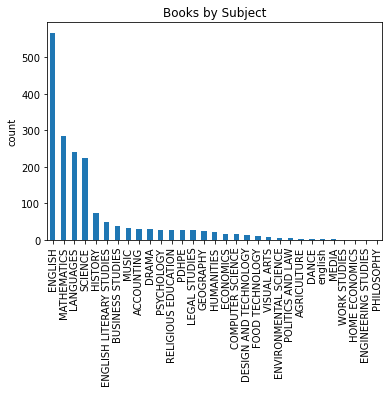

In [55]:
result_df['Subject'].value_counts().plot(x = 'Subject', y = 'count', kind = 'bar',ylabel='count', title='Books by Subject' )
#Interesting observation that when run on partial dataset (first 1000 rows from Googlebooks
#batch, the 'missing books were not the highest ranked.

<AxesSubplot:>

/Users/paulkirkwood/miniforge3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12362 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/paulkirkwood/miniforge3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12409 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/paulkirkwood/miniforge3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12435 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/paulkirkwood/miniforge3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12392 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/paulkirkwood/miniforge3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 12358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/paulkirkwood/miniforge3/lib/python3.9/

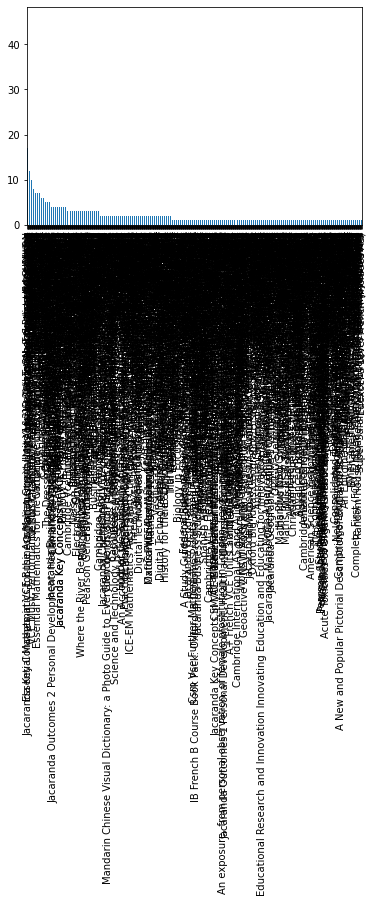

In [25]:
result_df['title'].value_counts().plot(x = 'title', y = 'count', kind = 'bar', )

heavily skewed data towards core subjects of english maths and languages.

In [39]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulkirkwood/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
for i in stop:
    result_df['description'] = result_df['description'].replace(to_replace=r'\b%s\b'%i, value="",regex=True)

In [108]:
combined_features = result_df[['Subject', 'title', 'authors', 'published', 'description']]
combined_features.head()

Subject                                 title  \
0  ENGLISH       Victorian Targeting Handwriting   
1  ENGLISH  Kluwell My Home Reading Yellow Level   
2  ENGLISH     Wilfrid Gordon McDonald Partridge   
3  ENGLISH                                IMaths   
4  ENGLISH                       Targeting Maths   

                                             authors published  \
0    Tricia Dearborn    Jo Ryan    Stephen Michae...      2004   
1                   Stan Kluzek    Andrew Coldwell        2019   
2                           Mem Fox    Julie Vivas        1987   
3      Mary Serenc    Chris Linthorne    Lena Ford        2011   
4                       Gloria Harris    Katy Pike        2013   

                                         description  
0  Targeting Handwriting Victoria Year 6 Student ...  
1                  Suitable  lower primary students   
2  The elderly Miss Nancy  helped  Wilfrid  repla...  
3    iMaths   investigative based numeracy progra...  
4                                                NaN

In [117]:
combined_features['combined'] = combined_features['Subject']+' '+\
                                combined_features['title']+' '+\
                                combined_features['authors']+' '+\
                                combined_features['description']

combined_features['combined'] = combined_features['combined'].apply(str)

In [118]:
import re


def clean_text(text):
    # remove backslash-apostrophe
    text = re.sub("\'", "", text)
    # remove everything except alphabets
    text = re.sub("[^a-zA-Z]"," ",text)
    # remove whitespaces
    text = ' '.join(text.split())
    # convert text to lowercase
    text = text.lower()

    return text

combined_features['cleaned'] = combined_features['combined'].apply(lambda x: clean_text(x))

In [119]:
combined_features.dropna(inplace=True)

In [120]:
combined_features['cleaned'].head()


0    english victorian targeting handwriting tricia...
1    english kluwell my home reading yellow level s...
2    english wilfrid gordon mcdonald partridge mem ...
3    english imaths mary serenc chris linthorne len...
6    english kluwell my home reading yellow level s...
Name: cleaned, dtype: object

In [ ]:
# Extract random book for testing
test_books = combined_features['cleaned']
test_book = test_books.iloc[[4]]
test_book

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
tfidf_rev = tfidf_vectorizer.fit_transform((combined_features['cleaned']))

from sklearn.metrics.pairwise import cosine_similarity
book_tfidf = tfidf_vectorizer.transform(test_book)
cos_similarity_tfidf = map(lambda x: cosine_similarity(book_tfidf, x), tfidf_rev)
output = list(cos_similarity_tfidf)

output

[array([[0.0242549]]),
 array([[1.]]),
 array([[0.0065155]]),
 array([[0.01019116]]),
 array([[1.]]),
 array([[0.03134761]]),
 array([[0.0242549]]),
 array([[0.02232594]]),
 array([[0.0242549]]),
 array([[0.00850266]]),
 array([[1.]]),
 array([[1.]]),
 array([[0.00588555]]),
 array([[0.00445573]]),
 array([[0.]]),
 array([[0.]]),
 array([[1.]]),
 array([[0.0073171]]),
 array([[0.00469762]]),
 array([[0.97861036]]),
 array([[0.]]),
 array([[0.01744521]]),
 array([[0.00298852]]),
 array([[0.]]),
 array([[0.01875018]]),
 array([[1.]]),
 array([[0.]]),
 array([[0.]]),
 array([[0.00785728]]),
 array([[0.01744521]]),
 array([[0.]]),
 array([[0.07592444]]),
 array([[1.]]),
 array([[0.03134761]]),
 array([[0.02282551]]),
 array([[0.0393714]]),
 array([[0.02232594]]),
 array([[0.01876448]]),
 array([[0.]]),
 array([[1.]]),
 array([[0.0242549]]),
 array([[0.00850266]]),
 array([[1.]]),
 array([[1.]]),
 array([[0.00744234]]),
 array([[0.00778975]]),
 array([[0.]]),
 array([[0.07592444]]),
 array(

In [ ]:
top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)[:20]
list_scores = [output[i][0][0] for i in top]

for i in top:
    title_rec = result.iloc[i, 5]
    isbn_rec = result.iloc[i, 4]
    print(isbn_rec, title_rec)

In [60]:
# Produce a Test/train Model for accuracy analysis

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
tfidf_vec = TfidfVectorizer(max_df=0.7, max_features=10000)
m_bin = MultiLabelBinarizer()
m_bin.fit(combined_features['cleaned'])
y = m_bin.transform(combined_features['cleaned'].str.split(' '))


/Users/paulkirkwood/miniforge3/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:870: UserWarning: unknown class(es) ['aaron', 'ab', 'abalone', 'abandoned', 'abandons', 'abbas', 'abbey', 'abbotson', 'abbreviations', 'abc', 'abe', 'abel', 'abela', 'abhyasa', 'abia', 'abilities', 'ability', 'abjuring', 'able', 'aboriginal', 'abounds', 'about', 'abraham', 'abram', 'abridged', 'abrioux', 'abruptly', 'absolute', 'absolutely', 'absorb', 'absorbing', 'abstract', 'abundance', 'abuse', 'abused', 'abyss', 'ac', 'academic', 'academics', 'academy', 'acara', 'accelerated', 'accelerating', 'acceleration', 'acceptance', 'accepted', 'accepts', 'access', 'accessed', 'accessibility', 'accessible', 'accident', 'accidentally', 'accidents', 'acclaimed', 'acclaims', 'accommodation', 'accompanied', 'accompanies', 'accompaniment', 'accompany', 'accompanying', 'accompanys', 'accordance', 'according', 'accordingly', 'account', 'accountant', 'accountants', 'accounting', 'accounts', 'accumulate', 'accur

In [61]:
#create split for training and validation data
xtrain, xval, ytrain, yval = train_test_split(combined_features['cleaned'],y, test_size=0.3, random_state=123)

In [62]:
xtrain_tfidf = tfidf_vec.fit_transform(xtrain)
xval_tfidf = tfidf_vec.transform(xval)

In [ ]:
print(xtrain)

In [76]:
print(xtrain_tfidf)
#Note the presence of value = 1 that signifies the same book being used across different years/regions

  (0, 8025)	0.05786582276240948
  (0, 5840)	0.07160303839686313
  (0, 7554)	0.06750457415748229
  (0, 193)	0.10453276575077902
  (0, 2497)	0.07306157829995806
  (0, 6958)	0.06460825874749544
  (0, 1066)	0.08683325688204233
  (0, 7856)	0.08844389581526353
  (0, 7887)	0.06274498623204022
  (0, 8012)	0.13334127978322036
  (0, 5914)	0.08331144671941407
  (0, 4158)	0.07547928927496948
  (0, 7852)	0.08607565087758694
  (0, 5513)	0.07505473422834316
  (0, 6953)	0.07831653798323945
  (0, 3032)	0.09020115007872599
  (0, 90)	0.05134174187114439
  (0, 3599)	0.05559066946044069
  (0, 3838)	0.056694768648057524
  (0, 5516)	0.10101095558815075
  (0, 1695)	0.1277892787619915
  (0, 4425)	0.07926038490142429
  (0, 438)	0.08607565087758694
  (0, 7254)	0.11142246911009095
  (0, 4270)	0.09317879814370617
  :	:
  (822, 5549)	0.12374979625218711
  (822, 2319)	0.10284202783397174
  (822, 2215)	0.09638785659436797
  (822, 6989)	0.11505275839338239
  (822, 6153)	0.10140728153337836
  (822, 4914)	0.371249388756

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score

In [66]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [67]:
clf.fit(xtrain_tfidf, ytrain)

/Users/paulkirkwood/miniforge3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 0 is present in all training examples.
  warnings.warn(
/Users/paulkirkwood/miniforge3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 17 is present in all training examples.
  warnings.warn(
/Users/paulkirkwood/miniforge3/lib/python3.9/site-packages/sklearn/multiclass.py:79: UserWarning: Label not 26 is present in all training examples.
  warnings.warn(


OneVsRestClassifier(estimator=LogisticRegression())

In [73]:
clf.get_params()

{'estimator__C': 1.0,
 'estimator__class_weight': None,
 'estimator__dual': False,
 'estimator__fit_intercept': True,
 'estimator__intercept_scaling': 1,
 'estimator__l1_ratio': None,
 'estimator__max_iter': 100,
 'estimator__multi_class': 'auto',
 'estimator__n_jobs': None,
 'estimator__penalty': 'l2',
 'estimator__random_state': None,
 'estimator__solver': 'lbfgs',
 'estimator__tol': 0.0001,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': LogisticRegression(),
 'n_jobs': None}

In [74]:
# create Prediction model
y_pred = clf.predict(xval_tfidf)
print(y_pred)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [123]:
# produce accurancy score
f1_score(yval, y_pred, average='micro')









0.0962962962962963

In [57]:
## DEVELOP RATINGS FOR BOOKS
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#extract the ratings data from the original dataset

collab_dataset = result[['School_ID','Subject', 'isbn', 'rating', 'score']]


<AxesSubplot:title={'center':'Average Scores'}, xlabel='Score (out of 5)', ylabel='Count'>

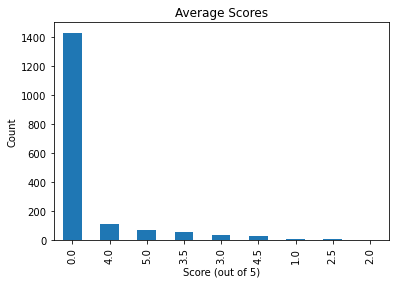

In [53]:
result['score'].value_counts().plot(x = 'isbn', y = 'count', kind = 'bar', title = "Average Scores", ylabel= 'Count', xlabel= 'Score (out of 5)')
#noted an issue that very few books had reviews, data sparcity will be an issue
#this may lead to 'cold start' issues when the recommender is first developed
#implicit v explicit ratings

In [49]:
counts = result['score'].value_counts()
counts


0.0    1433
4.0     106
5.0      65
3.5      54
3.0      31
4.5      28
1.0       4
2.5       3
2.0       1
Name: score, dtype: int64

In [144]:
train_set = collab_dataset[['School_ID', 'isbn', 'rating']]
train_set.head()

School_ID           isbn  rating
0          8  9781741250879     0.0
1          9  9780648237327     0.0
2         15  9781742990682    58.0
3         15  9781741351750     0.0
4         15  9781742152196     0.0

In [126]:
X_train, ydf_train = train_set.sample(frac=0.7, random_state=123)
df_test = train_set.drop(df_train.index)
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

In [ ]:
X_train, y_train = df_train.loc[:, ~df_train.columns.isin(['rating'])], df_train['rating']
X_test,  y_test  = df_test.loc [:, ~df_test.columns.isin(['rating'])], df_test['rating']_train = df_train.loc[:, ~df_train.columns.isin(['rating'])], df_train['rating']
X_test,  y_test  = df_test.loc [:, ~df_test.columns.isin(['rating'])], df_test['rating']


In [127]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [191]:
from sklearn.svm import SVC
classifier = SVC(random_state = 0)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)


ModuleNotFoundError: No module named 'sklearn.svd'

In [ ]:
output2 = model.predict(X_train)

In [184]:
output3 = model.fit(test_book2, y_train)

ValueError: Expected 2D array, got 1D array instead:
array=[1.50000000e+01 9.78174215e+12 0.00000000e+00 0.00000000e+00].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [216]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(X_train, y_train)

NearestNeighbors(algorithm='brute', metric='cosine')

In [221]:
test_rec = np.random.choice(X_train.shape[0])
print(test_rec)
print(df_train.iloc[test_rec,:].values.reshape(1,-1))

dist, indic = model_knn.kneighbors(X_train.iloc[test_rec,:].values.reshape(1, -1), n_neighbors = 6)
X_train.index[test_rec]

for i in range(0, len(dist.flatten())):
    if i==0:
        print('recommendations for {0}:\n'.format(df_train.index[test_rec]))
    else:
        print('{0}:{1}, distance of {2}:'.format(i, df_train.index[indic.flatten()[i]], dist.flatten()[i]))

884
[[2.50000000e+01 9.78019032e+12 0.00000000e+00]]
recommendations for 1155:

1:656, distance of 0.0:
2:965, distance of 0.0:
3:195, distance of 0.0:
4:1368, distance of 0.0:
5:1681, distance of 0.0:


/Users/paulkirkwood/miniforge3/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


In [ ]:
top = sorted(range(len(output)), key=lambda i: output[i], reverse=True)[:20]
list_scores = [output[i][0][0] for i in top]

for i in top:
    title_rec = result.iloc[i, 5]
    isbn_rec = result.iloc[i, 4]
    print(isbn_rec, title_rec)

In [225]:
test_book2 = collab_dataset.iloc[503]
test_book2.drop('Subject', inplace=True)
test_book2.array.reshape(1,-1)

/Users/paulkirkwood/miniforge3/lib/python3.9/site-packages/pandas/core/generic.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(obj)


<PandasArray>
[
[10, 9780375842207, 2495.0, 4.5]
]
Shape: (1, 4), dtype: object

In [226]:
from sklearn.metrics.pairwise import cosine_similarity
book_rating = model.predict(test_book2)
cos_similarity_rating = map(lambda x: cosine_similarity(book_rating, x), output2)
output2 = list(cos_similarity_rating)

/Users/paulkirkwood/miniforge3/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


ValueError: Expected 2D array, got 1D array instead:
array=[1.00000000e+01 9.78037584e+12 2.49500000e+03 4.50000000e+00].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [227]:
top2 = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:20]
list_scores = [output2[i] for i in top]

for i in top2:
    title_rec = result.iloc[i, 5]
    isbn_rec = result.iloc[i, 4]
    rat_rec = result.iloc[i,8]
    print(isbn_rec, rat_rec, title_rec)


9781741351811 0.0 IMaths
9780198603276 2.0 The Pocket Oxford Greek Dictionary
9781741353501 0.0 Sound Waves Foundation Student Book
9780190303488 0.0 Oxford Australian Integrated School Dictionary and Thesaurus
9781473221628 0.0 Dune: House Corrino
9780143505730 0.0 Natural Born Loser
9781925945065 0.0 ATAR Notes Text Guide: Burial Rites
9781741353389 0.0 Think Mentals Student Book 3
9781743305751 0.0 Strategies to Achieve Reading Success
9781488611261 0.0 Heinemann Physics 11 Enhanced
9781488611247 0.0 Heinemann Chemistry 1
9781741351811 0.0 IMaths
9780195508697 3.0 Biology
9780170393720 0.0 Tapis Volant 1 4th Edition Student Book
9781488621284 0.0 New Wave Mental Maths
9780190310769 0.0 Jacaranda Atlas Ninth Edition EBookPLUS and Print
9781118489291 0.0 Geography Alive 10 for the Australian Curriculum
9780143304852 0.0 Thai-riffic!
9781922246172 0.0 ORIGO Stepping Stones Student Journal Year F
9781488695971 nan nan


In [231]:
from sklearn.metrics import r2_score, mean_squared_error
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'R-Squared',r2)
print(f'MSE', mse)

R-Squared -0.01818128485161008
MSE 145560.9671814672


In [147]:
from sklearn.svm import SVC
classifier = SVC(random_state = 0)
classifier.fit(X_train,y_train)
y_pred = classifier.predict(X_test)


